<h1 align="center">
  <a href="https://uptrain.ai">
    <img width="300" src="https://user-images.githubusercontent.com/108270398/214240695-4f958b76-c993-4ddd-8de6-8668f4d0da84.png" alt="UpTrain">
  </a>
</h1>

<div style="text-align: center;">

# Retrieving Context Documents using QDrant & Evaluating the Quality of Retrieved Context using UpTrain
</div>





## What is a Vector Database?
Vector databases store data as high-dimensional vectors, enabling fast and efficient similarity search and retrieval of data based on their vector representations.

This is particularly useful for large language models (LLMs), which need to process vast amounts of data and find relevant information quickly.

## What role does Qdrant play in your RAG based application?
[Qdrant](https://github.com/qdrant/qdrant) (pronounced: quadrant) is a vector similarity search engine and vector database. While working on RAG based applications, you can use QDrant to retrieve information from your context documents.

## Why do I need to monitor the retrieval quality?
Let's say a user asks your LLM application a question on refunds, maybe something like: "how can I initiate a refund on my last purchase", ideally you need the retrieved context to contain 2 important information: "the user's last purchase" and "company policy on refunds", now what if the retrieved context doesnt contain that information or just that the information fetched is irrelevant. That's where UpTrain comes in, by helping you evaluate the relevance of the retrieved context.  

## Overview of this notebooks
In this notebook we'll walk you through some basic applications in RAG, using QDrant as a vector DB for your context documents, further using UpTrain to evaluate the quality (relevance) of the retrieved context. For simplicity, we can divide this notebook in 3 parts:
1. Data Preparation and Embedding:
 We'll begin by processing and embedding our data using a suitable sentence transformer model. This creates high-dimensional vector representations capturing the semantic meaning of each data point.
2. Vector Search with Qdrant:
We'll leverage Qdrant's efficient vector search capabilities to retrieve relevant results based on a query vector, allowing us to explore the semantic relationships within the data.
3. UpTrain Evaluation of Retrieved Content:
 Utilizing UpTrain's pre-built and custom evaluation checks, we'll analyze the quality of the retrieved search results. This assessment focuses on aspects like response relevance, factual accuracy, and completeness, providing valuable insights into the effectiveness of the search process.

Also, if you face any difficulties, need some help with using UpTrain or want to brainstorm on custom evaluations for your use-case, [speak to the maintainers of UpTrain here](https://calendly.com/uptrain-sourabh/30min).

### Step 1 : Install all the libraries and make necessary imports

In [1]:
# !pip install qdrant-client
# !pip install -U sentence-transformers
# !pip install uptrain

In [2]:
import polars as pl  # For data manipulation
from qdrant_client import models, QdrantClient  # Qdrant client for vector search
from sentence_transformers import SentenceTransformer  # Model for generating embeddings
from uptrain import APIClient, Evals  # UpTrain client for embedding evaluation

### Step 2: Define your document to be embedded

In [3]:
# Load data (adjust based on your data source)
# Assuming you have a list of texts for Qdrant embedding and evaluation

# Let's make a semantic search for Sci-Fi books!
texts = [
  {"name": "A Gift From The Stars", "description": "This is the true story of an abduction and a rescue by benevolent extraterrestrials, various direct contacts Elena Danaan had throughout the years with UFOs and visitors from other worlds.",
   "author": "Elena Dannan", "year": 2020},
  { "name": "The Time Machine", "description": "A man travels through time and witnesses the evolution of humanity.",
   "author": "H.G. Wells", "year": 1895 },
  { "name": "Ender's Game", "description": "A young boy is trained to become a military leader in a war against an alien race.",
   "author": "Orson Scott Card", "year": 1985 },
  { "name": "The Royal Abduction", "description": "Shreya Singh, a princess from Rajasthan, has been abducted! A woman of beauty and substance, she is living a lavish life. But while there are abundant riches in her palace, there are also dark secrets about her family buried in the past.",
   "author": "Vikram Singh", "year": 2023 },
]
  # You can replace this demo data with your actual text data


### Step 3: Choose your embedding model and create a memory instance for the same

In [4]:
# Create sentence transformer model
encoder = SentenceTransformer('all-MiniLM-L6-v2')           # Choose the embedding model

qdrant = QdrantClient(":memory:")                           # Create in-memory Qdrant instance

# Create collection to store books
qdrant.recreate_collection(
    collection_name="my_books",
    vectors_config=models.VectorParams(
        size=encoder.get_sentence_embedding_dimension(),    # Vector size is defined by used model
        distance=models.Distance.COSINE
    )
)

True

### Step 4: Generate embedding and vectorise from the defined text in the previous step


In [5]:
embeddings = encoder.encode(texts)                              # Generate embeddings for the texts
qdrant.upload_records(
    collection_name="my_books",                                 # Upload to the specified collection
    records=[models.Record(id=idx, vector=embedding.tolist()) for idx, embedding in enumerate(embeddings)]  # Create Qdrant records
)


qdrant.upload_records(                                          # Let's vectorize descriptions and upload to qdrant
    collection_name="my_books",
    records=[
        models.Record(
            id=idx,
            vector=encoder.encode(doc["description"]).tolist(),
            payload=doc
        ) for idx, doc in enumerate(texts)
    ]
)

/var/folders/1x/fsdzc0ks0s12hld1fhd0gldh0000gn/T/ipykernel_45230/585974804.py:2: DeprecationWarning: `upload_records` is deprecated, use `upload_points` instead
  qdrant.upload_records(
/var/folders/1x/fsdzc0ks0s12hld1fhd0gldh0000gn/T/ipykernel_45230/585974804.py:8: DeprecationWarning: `upload_records` is deprecated, use `upload_points` instead
  qdrant.upload_records(                                          # Let's vectorize descriptions and upload to qdrant


In [6]:
question = 'What are some books that talk about alien abductions'     # Create a question to evaluate the context


hits = qdrant.search(                                                # Fetch relevant information from Qdrant
    collection_name="my_books",
    query_vector=encoder.encode(question).tolist()
)

data =[]                                                             # Store the results in required format
for hit in hits:
    data.append({
        'question': question,
        'context': "Book Description for " +hit.payload.get("name", "")+" : "+hit.payload.get("description", "")
    })

## Step 5: Evaluating the retrieved context's quality using UpTrain's Open-Source Software (OSS)


In [7]:
from uptrain import EvalLLM, Evals, APIClient, Settings
import json


OPENAI_API_KEY = "sk-###############"  # Insert your OpenAI key here
    
eval_llm = EvalLLM(Settings(openai_api_key=OPENAI_API_KEY, response_format={"type":"json_object"}))

res = eval_llm.evaluate(
    data = data,
    checks = [Evals.CONTEXT_RELEVANCE]
)

print(json.dumps(res, indent=3))


2024-01-29 19:15:54.611 | INFO     | uptrain.framework.evalllm:evaluate:100 - Sending evaluation request for rows 0 to <50 to the Uptrain


[
   {
      "question": "What are some books that talk about alien abductions",
      "context": "Book Description for A Gift From The Stars : This is the true story of an abduction and a rescue by benevolent extraterrestrials, various direct contacts Elena Danaan had throughout the years with UFOs and visitors from other worlds.",
      "score_context_relevance": 1.0,
      "explanation_context_relevance": "The extracted context provides a specific book description that directly addresses the question about books on alien abductions. It mentions 'the true story of an abduction and a rescue by benevolent extraterrestrials' and 'various direct contacts Elena Danaan had throughout the years with UFOs and visitors from other worlds.' This information can be used to recommend the book 'A Gift From The Stars' as a relevant answer to the question. Hence, the selected choice is (A)"
   },
   {
      "question": "What are some books that talk about alien abductions",
      "context": "Book De

## [Optional] Step 6: UpTrain Managed Service and Dashboards

You can create a free UpTrain account [here](https://uptrain.ai/) and get free trial credits. If you want more trial credits, [book a call with the maintainers of UpTrain here](https://calendly.com/uptrain-sourabh/30min).

UpTrain Managed service provides:
1. Dashboards with advanced drill-down and filtering options
2. Insights and common topics among failing cases
3. Observability and real-time monitoring of production data
4. Regression testing via seamless integration with your CI/CD pipelines

In [8]:
from uptrain import EvalLLM, Evals, APIClient
import json 

UPTRAIN_API_KEY = "up-###################"  # Replace with your UpTrain API key

uptrain_client = APIClient(Settings(uptrain_access_token = UPTRAIN_API_KEY, response_format={"type":"json_object"}))

res = uptrain_client.log_and_evaluate(
    "Qdrant-context-sample-evals",
    data,
    [Evals.CONTEXT_RELEVANCE]
)

print(json.dumps(res, indent=3))

2024-01-29 19:15:55.742 | INFO     | uptrain.framework.remote:log_and_evaluate:507 - Sending evaluation request for rows 0 to <50 to the Uptrain server


[
   {
      "question": "What are some books that talk about alien abductions",
      "context": "Book Description for A Gift From The Stars : This is the true story of an abduction and a rescue by benevolent extraterrestrials, various direct contacts Elena Danaan had throughout the years with UFOs and visitors from other worlds.",
      "score_context_relevance": 1.0,
      "explanation_context_relevance": "The extracted context provides a specific book description that directly addresses the question about books on alien abductions. It mentions 'the true story of an abduction and a rescue by benevolent extraterrestrials' and 'various direct contacts Elena Danaan had throughout the years with UFOs and visitors from other worlds.' This information can be used to recommend the book 'A Gift From The Stars' as a relevant answer to the question. Hence, the selected choice is (A)"
   },
   {
      "question": "What are some books that talk about alien abductions",
      "context": "Book De

### Dashboards: 
Histogram of score vs number of cases with that score

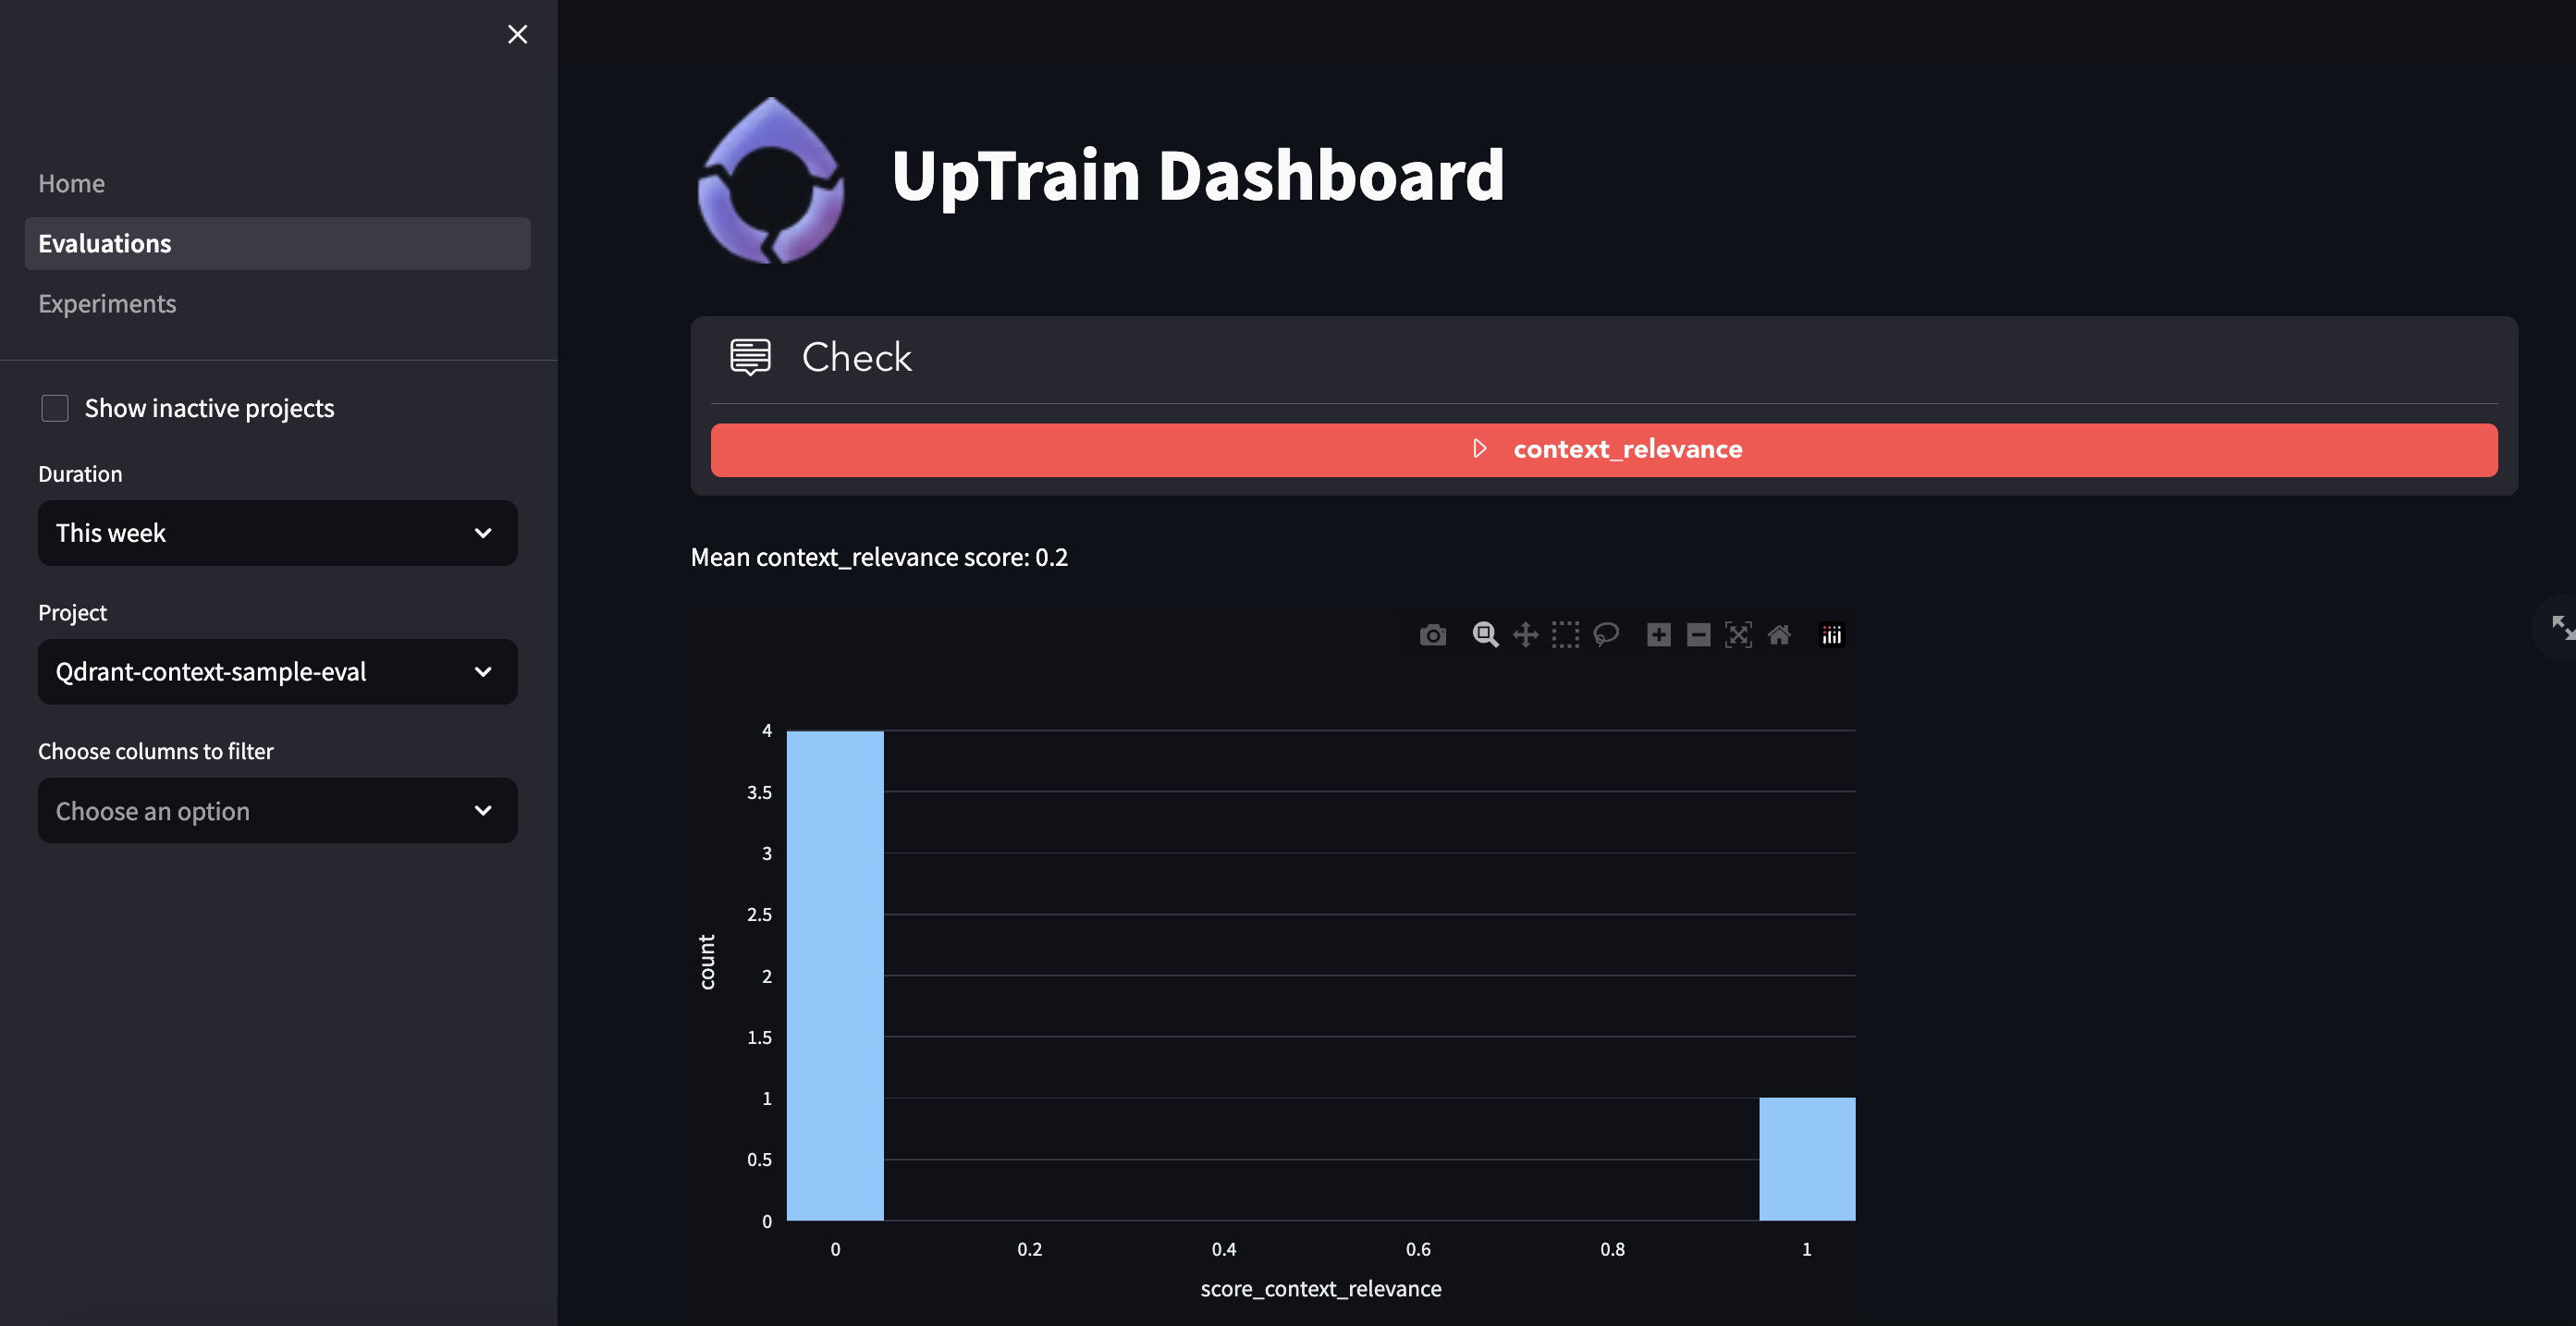

You can access the uptrain dashboards [here](https://demo.uptrain.ai/dashboard/) by using the above defined UPTRAIN_API_KEY


### Insights:
You can filter failure cases and generate common topics among them. This can help identify the core issue and help fix it

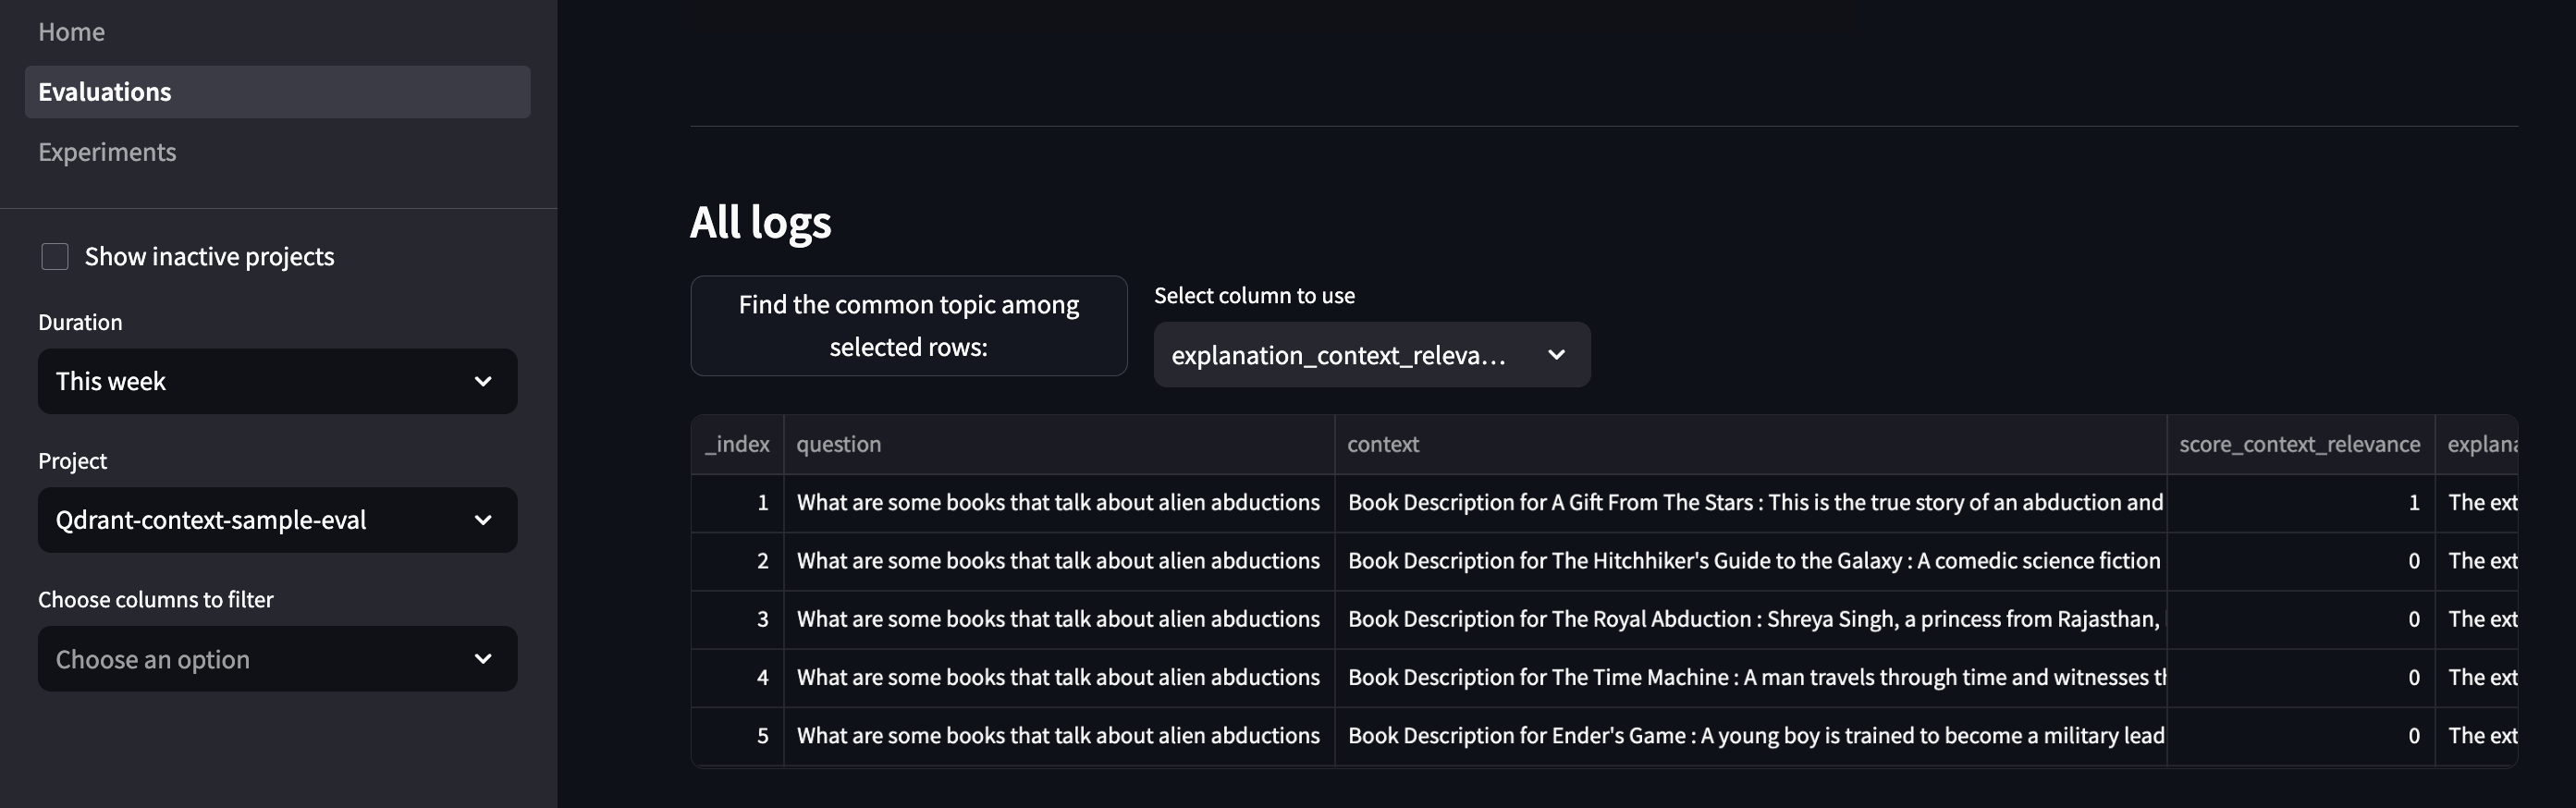
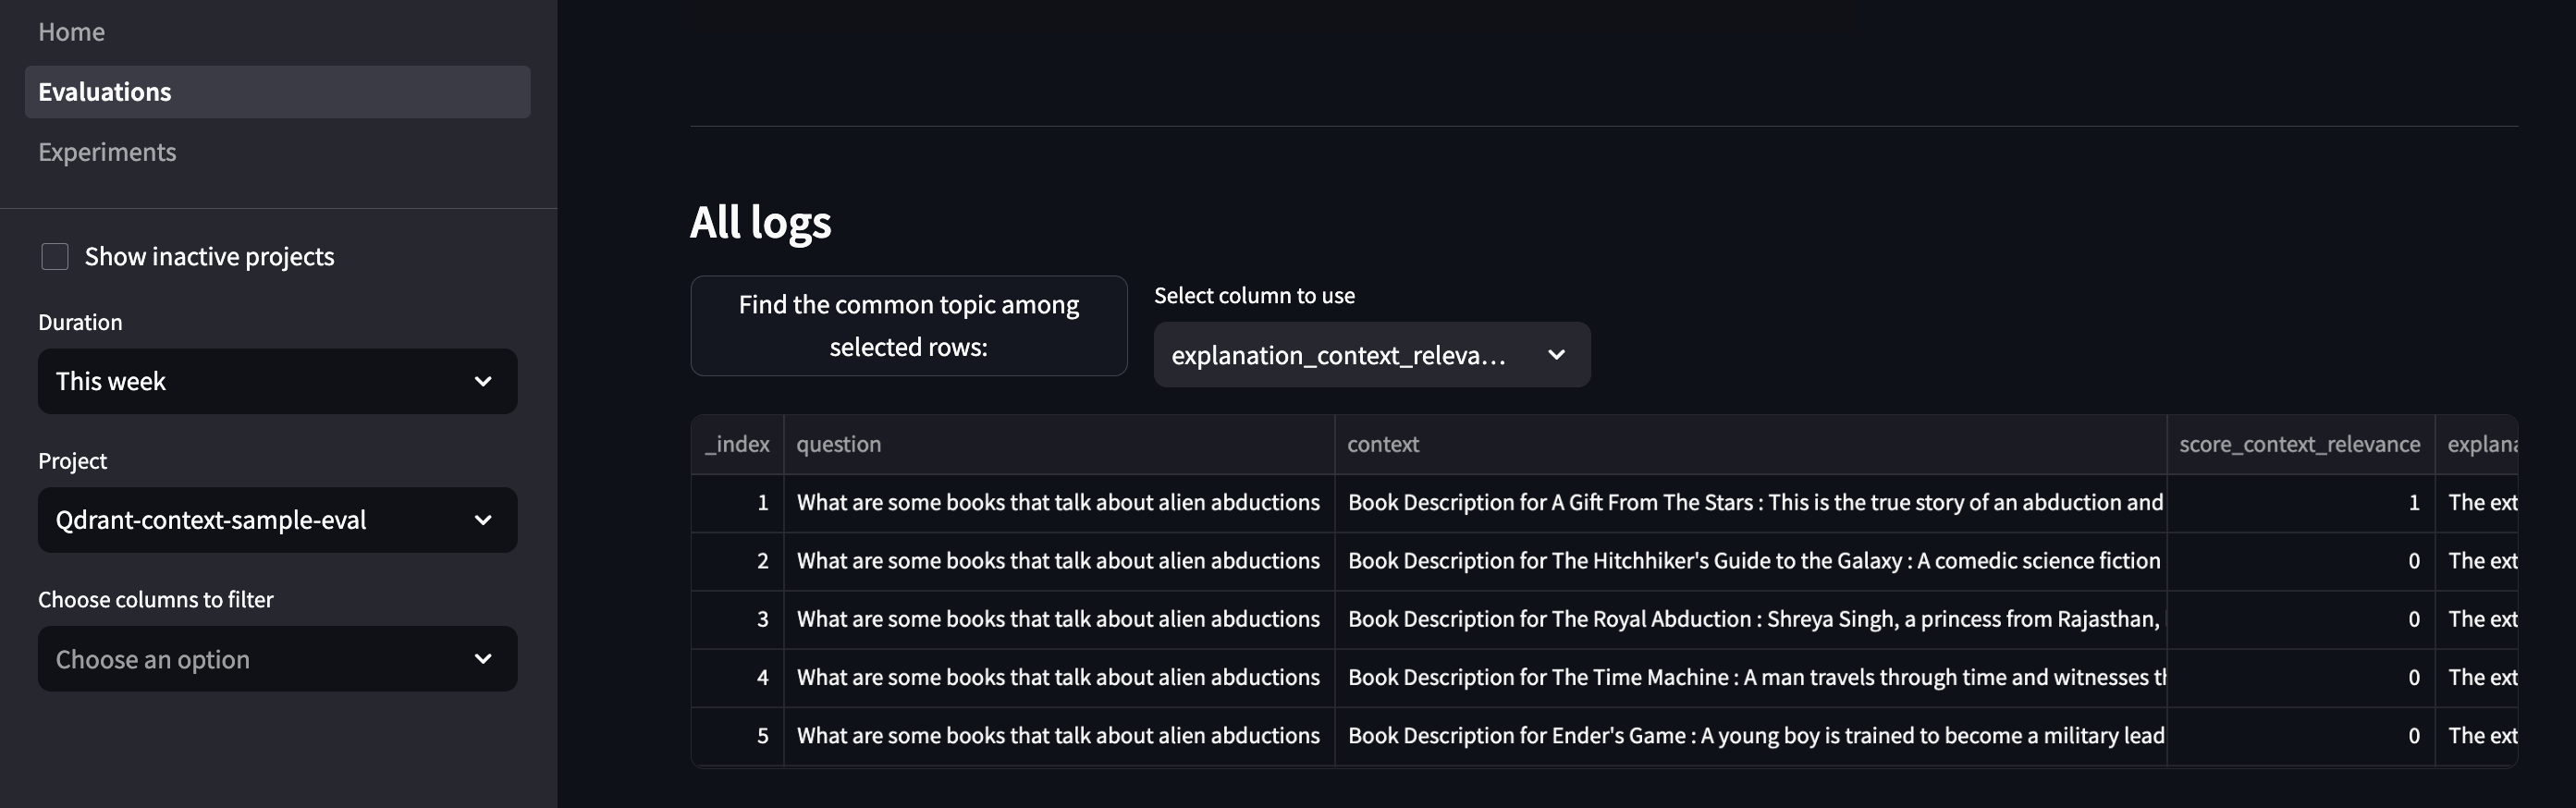